<a href="https://colab.research.google.com/github/mx60s/echo-state-belief-geometry/blob/main/belief_geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!python -m pip install -U mpltern -q

In [1]:
import collections, random

class GeneratorModel:
  def __init__(self, states: list, trans_matrix: dict,
                 obs_matrix: dict):
    self.states = states
    self.trans_matrix = trans_matrix
    self.obs_matrix = obs_matrix

  def transition(self, start):
    # get obs
    obs_probs = self.obs_matrix[start]
    obs = random.choices(list(obs_probs.keys()),
                         weights=list(obs_probs.values()), k=1)[0]
    # get state
    state = random.choices(self.states,
                           weights=self.trans_matrix[start], k=1)[0]
    return obs, state

  def generate_sequence(self, length, start):
    observations = []
    states = []
    curr_state = start
    for _ in range(length):
      obs, curr_state = self.transition(curr_state)
      observations.append(obs)
      states.append(curr_state)

    return observations, states

In [2]:

transition_matrix = {
    'S1': [0.90, 0.05, 0.05],
    'S2': [0.05, 0.90, 0.05],
    'S3': [0.05, 0.05, 0.90],
}

observation_matrix = {
    'S1': {0: 0.85, 1: 0.075, 2: 0.075},
    'S2': {0: 0.075, 1: 0.85, 2: 0.075},
    'S3': {0: 0.075, 1: 0.075, 2: 0.85},
}

mess3 = GeneratorModel(states=['S1', 'S2', 'S3'],
                       trans_matrix=transition_matrix,
                       obs_matrix=observation_matrix)

mess3.generate_sequence(length=20, start='S1')


([0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2],
 ['S1',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3',
  'S3'])

In [52]:
def norm(distribution):
  total = sum(distribution.values())
  for state in distribution.keys():
    distribution[state] /= total

  return distribution

def msp_update_obs(obs: int, prior_dist: dict, generator: GeneratorModel):
    # update on observation
    posterior = {}
    for i, state in enumerate(prior_dist.keys()):
        posterior[state] = generator.trans_matrix[state][obs] * prior_dist[state]

    prior_dist = norm(posterior)

    # propagate
    posterior = {}
    for i, state in enumerate(prior_dist.keys()):
        prob = sum([generator.trans_matrix[prev_state][i] * prior_dist[prev_state] for prev_state in prior_dist.keys()])
        posterior[state] = prob

    return norm(posterior)


In [50]:
from tqdm import tqdm, trange

def take_walks(initial_distribution: dict, generator: GeneratorModel, steps: int,
                     n_generate: int = 15):
    distros = []
    for i in trange(steps):
        p = initial_distribution
        obs, states = generator.generate_sequence(length=n_generate, start='S1')
        for o in obs:
            p = msp_update_obs(o, p, generator)
        distros.append(list(p.values()))
    return distros

mess3_initial = {'S1': 1/3, 'S2': 1/3, 'S3': 1/3}
beliefs = take_walks(mess3_initial, mess3, 50000)

100%|██████████| 50000/50000 [00:08<00:00, 6167.79it/s]


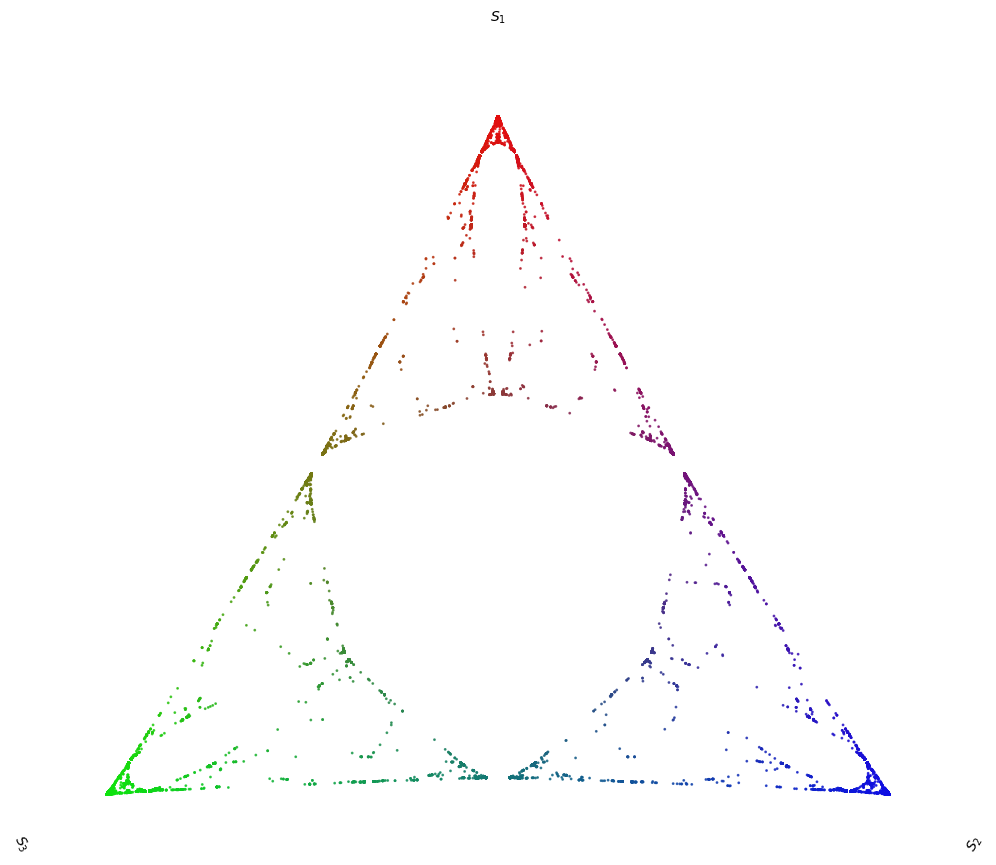

In [55]:
import matplotlib.pyplot as plt
import mpltern

labels = ['$S_1$', '$S_2$', '$S_3$']

fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(projection="ternary", ternary_sum=1.0)

ax.set_tlabel(labels[0])
ax.set_rlabel(labels[1])
ax.set_llabel(labels[2])

ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.taxis.set_ticks([])
ax.laxis.set_ticks([])
ax.raxis.set_ticks([])

ax.taxis.set_ticklabels([])
ax.laxis.set_ticklabels([])
ax.raxis.set_ticklabels([])

t, l, r = zip(*beliefs)
ax.scatter(t, l, r, alpha=0.8, s=1,
           c=[(t[i], l[i], r[i]) for i in range(len(t))])

plt.show()


In [56]:
import numpy as np

class EchoStateNetwork:
    def __init__(
        self,
        input_dim,
        reservoir_size=500,
        spectral_radius=0.95,
        sparsity=0.1,
        leak_rate=1.0,
        random_seed=42
    ):

        self.res_size = reservoir_size
        self.leak = leak_rate
        rng = np.random.RandomState(random_seed)

        self.Win = rng.uniform(-1, 1, size=(reservoir_size, input_dim))

        W = rng.uniform(-1, 1, size=(reservoir_size, reservoir_size))
        mask = rng.rand(reservoir_size, reservoir_size) < sparsity
        W[mask] = 0.0

        eigs = np.abs(np.linalg.eigvals(W))
        W *= (spectral_radius / eigs.max())
        self.W = W

        self.x = np.zeros((reservoir_size,))

    def step(self, input_vector):
        pre_act = self.W.dot(self.x) + self.Win.dot(input_vector)
        x_new = np.tanh(pre_act)
        self.x = (1 - self.leak) * self.x + self.leak * x_new
        return self.x.copy()

    def run_sequence(self, input_sequence, reset_state=True):
        if reset_state:
            self.x[:] = 0.0
        states = []
        for u in input_sequence:
            states.append(self.step(u))
        return np.vstack(states)


class OneHot:
    def __init__(self, obs_symbols):
        self.symbols = list(obs_symbols)
        self.idx = {s: i for i, s in enumerate(self.symbols)}
        self.dim = len(self.symbols)

    def encode(self, observation):
        vec = np.zeros((self.dim,), dtype=float)
        vec[self.idx[observation]] = 1.0
        return vec

    def encode_sequence(self, obs_sequence):
        return np.vstack([self.encode(o) for o in obs_sequence])


In [57]:
encoder = OneHot([0,1,2])
esn = EchoStateNetwork(input_dim=3, reservoir_size=200, spectral_radius=0.9, sparsity=0.3, leak_rate=0.3)

In [59]:
# idek that you need nearly this much data, it seems to be fine like immediately

num_sequences = 400
sequence_length = 50

initial_distribution = {'S1': 1/3, 'S2': 1/3, 'S3': 1/3}

all_states = []
all_beliefs = []

for _ in tqdm(range(num_sequences), desc="Collecting sequences"):
    prior = initial_distribution
    esn.x[:] = 0.0

    obs_seq = []
    true_bels = []

    obs, states = mess3.generate_sequence(length=sequence_length, start='S1')
    for o in obs:
        prior = msp_update_obs(o, prior, mess3)

        obs_seq.append(o)
        true_bels.append(list(prior.values()))

    U = encoder.encode_sequence(obs_seq)
    X = esn.run_sequence(U, reset_state=False)

    all_states.append(X)
    all_beliefs.append(np.vstack(true_bels))

reservoir_states = np.vstack(all_states)
belief_states = np.vstack(all_beliefs)


In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# weird split just to show doesn't need much
X_train, X_test, y_train, y_test = train_test_split(reservoir_states, belief_states, test_size=0.53, random_state=42)

class LinearBeliefDecoder:
    def __init__(self):
        self.model = LinearRegression()

    def fit(self, reservoir_states, belief_states):
        """
        reservoir_states: (N, R)
        belief_states:   (N, K)
        """
        self.model.fit(reservoir_states, belief_states)

    def predict(self, reservoir_states):
        preds = self.model.predict(reservoir_states)
        # clip & renormalize
        preds[preds < 0] = 0.0
        sums = preds.sum(axis=1, keepdims=True)
        # avoid div by zero
        sums[sums == 0] = 1.0
        return preds / sums

decoder = LinearBeliefDecoder()
decoder.fit(X_train, y_train)
pred_belief_states = decoder.predict(X_test)

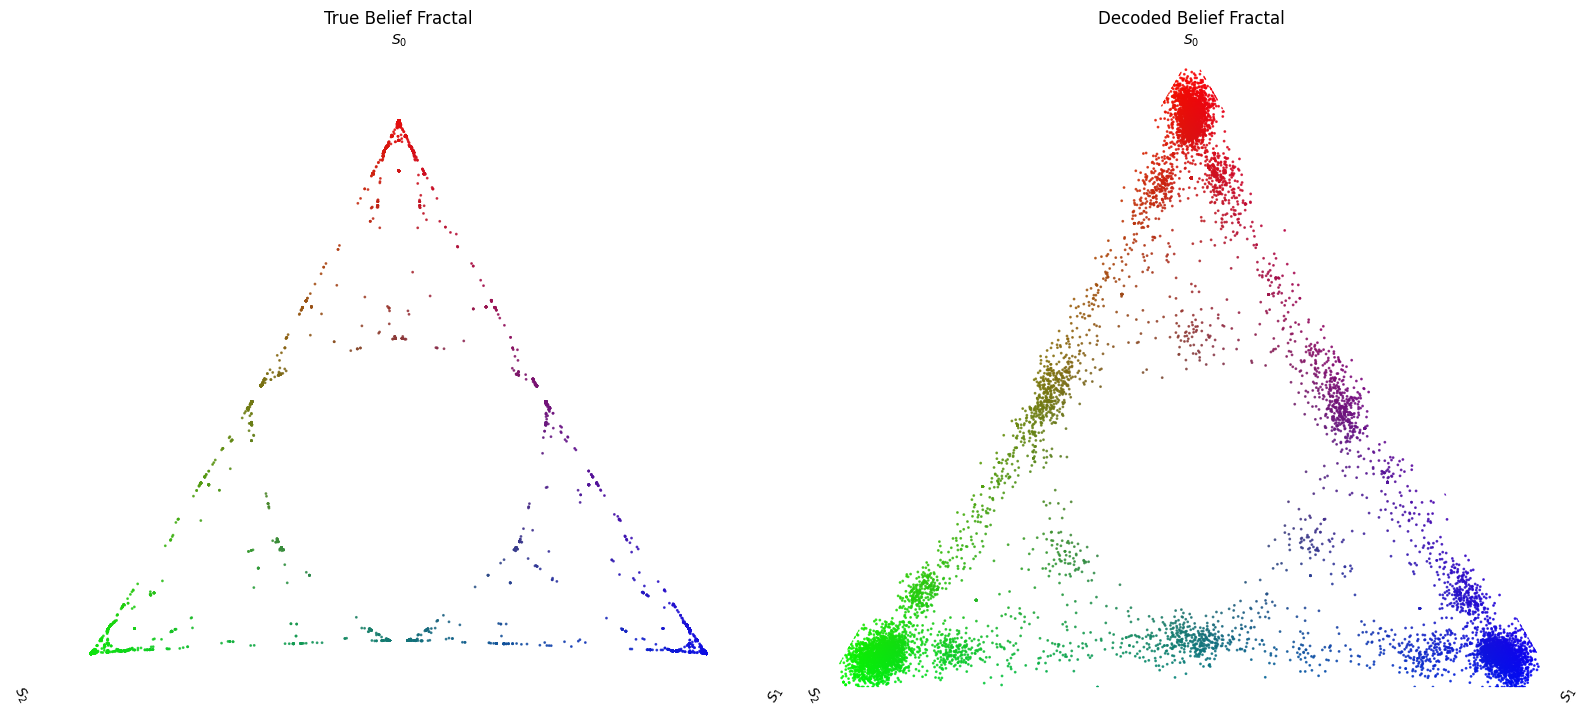

In [61]:
import matplotlib.pyplot as plt
import mpltern

labels = ['$S_0$', '$S_1$', '$S_2$']
titles = ["True Belief Fractal", "Decoded Belief Fractal"]
datasets = [y_test, pred_belief_states]

fig, axes = plt.subplots(1, 2, figsize=(16, 7),
                         subplot_kw={'projection': 'ternary', 'ternary_sum': 1.0})

for ax, data, title in zip(axes, datasets, titles):
    ax.set_tlabel(labels[0])
    ax.set_rlabel(labels[1])
    ax.set_llabel(labels[2])

    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.taxis.set_ticks([]); ax.taxis.set_ticklabels([])
    ax.laxis.set_ticks([]); ax.laxis.set_ticklabels([])
    ax.raxis.set_ticks([]); ax.raxis.set_ticklabels([])

    t, l, r = zip(*data)
    ax.scatter(t, l, r,
               alpha=0.8, s=1,
               c=[(t[i], l[i], r[i]) for i in range(len(t))])

    ax.set_title(title)

plt.tight_layout()
plt.show()
